# Мировой рейтинг университетов


Всемирный рейтинг университетов Times Higher Education

## Добавление нового атрибута

К существующему набору данных добавим показатель, который может отражать эффективность обучения относительно соотношения студентов и преподавателей. Это отношение может представлять собой некоторую меру того, насколько эффективно университет обеспечивает обучение своих студентов при заданном числе преподавателей.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from scipy import stats

data_frame = pd.read_csv("timesData.csv")
data_frame.dtypes

world_rank                 object
university_name            object
country                    object
teaching                  float64
international              object
research                  float64
citations                 float64
income                     object
total_score                object
num_students               object
student_staff_ratio       float64
international_students     object
female_male_ratio          object
year                        int64
dtype: object

Для упрощения задачи выберем следующие атрибуты:
- world_rank: место в мире
- university_name: Название университета
- country: Страна
- teaching: Уровень преподавания
- research: Исследования
- citations: Количество цитирований
- income: Доход
- student_staff_ratio: соотношение студентов и преподавателей
- year

In [3]:
data_frame['income'] = pd.to_numeric(data_frame['income'], errors='coerce')

cols = ['world_rank','university_name','country','teaching','research','citations','income','student_staff_ratio','year']
df = data_frame[cols].sort_values(by='world_rank', ascending=True)[:1000]

In [4]:
df['education_quality'] = df['teaching'] / df['student_staff_ratio']
df

,world_rank,university_name,country,teaching,research,citations,income,student_staff_ratio,year,education_quality
0,1,Harvard University,United States of America,99.7,98.7,98.8,34.5,8.9,2011,11.202247
200,1,California Institute of Technology,United States of America,95.7,98.2,99.9,97.0,6.9,2012,13.869565
1803,1,California Institute of Technology,United States of America,95.6,97.6,99.8,97.8,6.9,2016,13.855072
602,1,California Institute of Technology,United States of America,96.3,99.4,99.7,95.6,6.9,2013,13.956522
1402,1,California Institute of Technology,United States of America,92.2,98.1,99.7,89.1,6.9,2015,13.362319
...,...,...,...,...,...,...,...,...,...,...
458,251-275,Norwegian University of Science and Technology,Norway,26.9,26.9,41.5,49.7,13.9,2012,1.935252
457,251-275,National Sun Yat-Sen University,Taiwan,24.9,30.4,48.5,42.1,19.6,2012,1.270408
462,251-275,Tilburg University,Netherlands,22.6,49.4,23.6,36.0,22.4,2012,1.008929
876,251-275,Vienna University of Technology,Austria,44.8,32.4,34.2,65.5,52.0,2013,0.861538


## Причесывание датасета

- Идентифицировать и удалить выбросы, используя статистические методы.
- Обработать пропущенные значения, заполнив их средними значениями.
- Удалить дубликаты, если они присутствуют.
- Проверить данные на кривизну и произвести необходимые коррекции.

### Удаление выбросов

In [5]:
def find_outliers_std(series):
    std_dev = series.std()  
    mean = series.mean()  
    threshold = 3  

    outliers = (series > mean + threshold * std_dev) | (series < mean - threshold * std_dev)
    return outliers.sum()

def remove_outliers_std(df, column):
    std_dev = df[column].std()  
    mean = df[column].mean()  
    threshold = 3  

    df = df[(df[column] <= mean + threshold * std_dev) & (df[column] >= mean - threshold * std_dev)]
    return df

In [6]:
cols = ['teaching','research','citations','income','student_staff_ratio','year', 'education_quality']

for col in cols:
    print(f'{col} : {find_outliers_std(df[col])}')


for col in cols:
    df = remove_outliers_std(df, col)

teaching : 15
research : 2
citations : 0
income : 0
student_staff_ratio : 30
year : 0
education_quality : 25


### Удаление дубликатов

In [7]:
print(df.duplicated().sum() == 0)

True


### Обработка пропущенных значений


In [8]:
print(df.isnull().sum() == 0)
df

world_rank             True
university_name        True
country                True
teaching               True
research               True
citations              True
income                 True
student_staff_ratio    True
year                   True
education_quality      True
dtype: bool


,world_rank,university_name,country,teaching,research,citations,income,student_staff_ratio,year,education_quality
1812,10,University of Chicago,United States of America,85.7,88.9,99.2,36.6,6.9,2016,12.420290
1011,10,Imperial College London,United Kingdom,84.5,88.1,90.0,72.3,11.7,2014,7.222222
299,100,University of Alberta,Canada,50.6,54.4,51.7,53.7,21.6,2012,2.342593
1101,100,University of Helsinki,Finland,35.5,46.5,77.8,30.7,15.1,2014,2.350993
99,100,École Normale Supérieure de Lyon,France,51.1,34.4,88.8,26.1,8.0,2011,6.387500
...,...,...,...,...,...,...,...,...,...,...
459,251-275,Queen’s University Belfast,United Kingdom,26.5,21.3,42.0,41.9,17.9,2012,1.480447
458,251-275,Norwegian University of Science and Technology,Norway,26.9,26.9,41.5,49.7,13.9,2012,1.935252
457,251-275,National Sun Yat-Sen University,Taiwan,24.9,30.4,48.5,42.1,19.6,2012,1.270408
462,251-275,Tilburg University,Netherlands,22.6,49.4,23.6,36.0,22.4,2012,1.008929


### Обработка кривых данных

In [15]:
z_scores = np.abs((df[['teaching', 'research', 'citations', 'income', 'student_staff_ratio', 'year', 'education_quality']] - df[['teaching', 'research', 'citations', 'income', 'student_staff_ratio', 'year', 'education_quality']].mean()) / df[['teaching', 'research', 'citations', 'income', 'student_staff_ratio', 'year', 'education_quality']].std())

threshold = 3

num_before = len(df)
df = df[(z_scores < threshold).all(axis=1)]
num_after = len(df)

cols = ['teaching','research','citations','income','student_staff_ratio','year','education_quality']
df_n = df[cols].sort_values(by='year', ascending=True)[:1000]


print(f'Кривые данные: {num_before - num_after}')
print(num_after)
print(df_n)


Кривые данные: 10
657
      teaching  research  citations  income  student_staff_ratio  year  \
190       43.6      40.4       61.5    32.5                 15.7  2011   
174       42.1      40.4       62.8    29.7                 14.7  2011   
130       32.9      48.3       79.1    27.4                 21.5  2011   
175       46.8      44.1       52.5    38.4                 15.0  2011   
128       36.9      49.2       75.9    31.7                 23.7  2011   
...        ...       ...        ...     ...                  ...   ...   
2007      33.9      36.7       67.8    52.0                 16.5  2016   
2054      38.5      17.5       85.0    29.1                 11.8  2016   
2053      38.6      32.4       59.0    59.7                 20.7  2016   
2034      30.8      17.8       97.4    42.5                  7.2  2016   
1946      40.3      39.0       77.5    39.8                 15.0  2016   

      education_quality  
190            2.777070  
174            2.863946  
130        

## Определение числа кластеров

## Анализ атрибутов датасета

### Графический метод

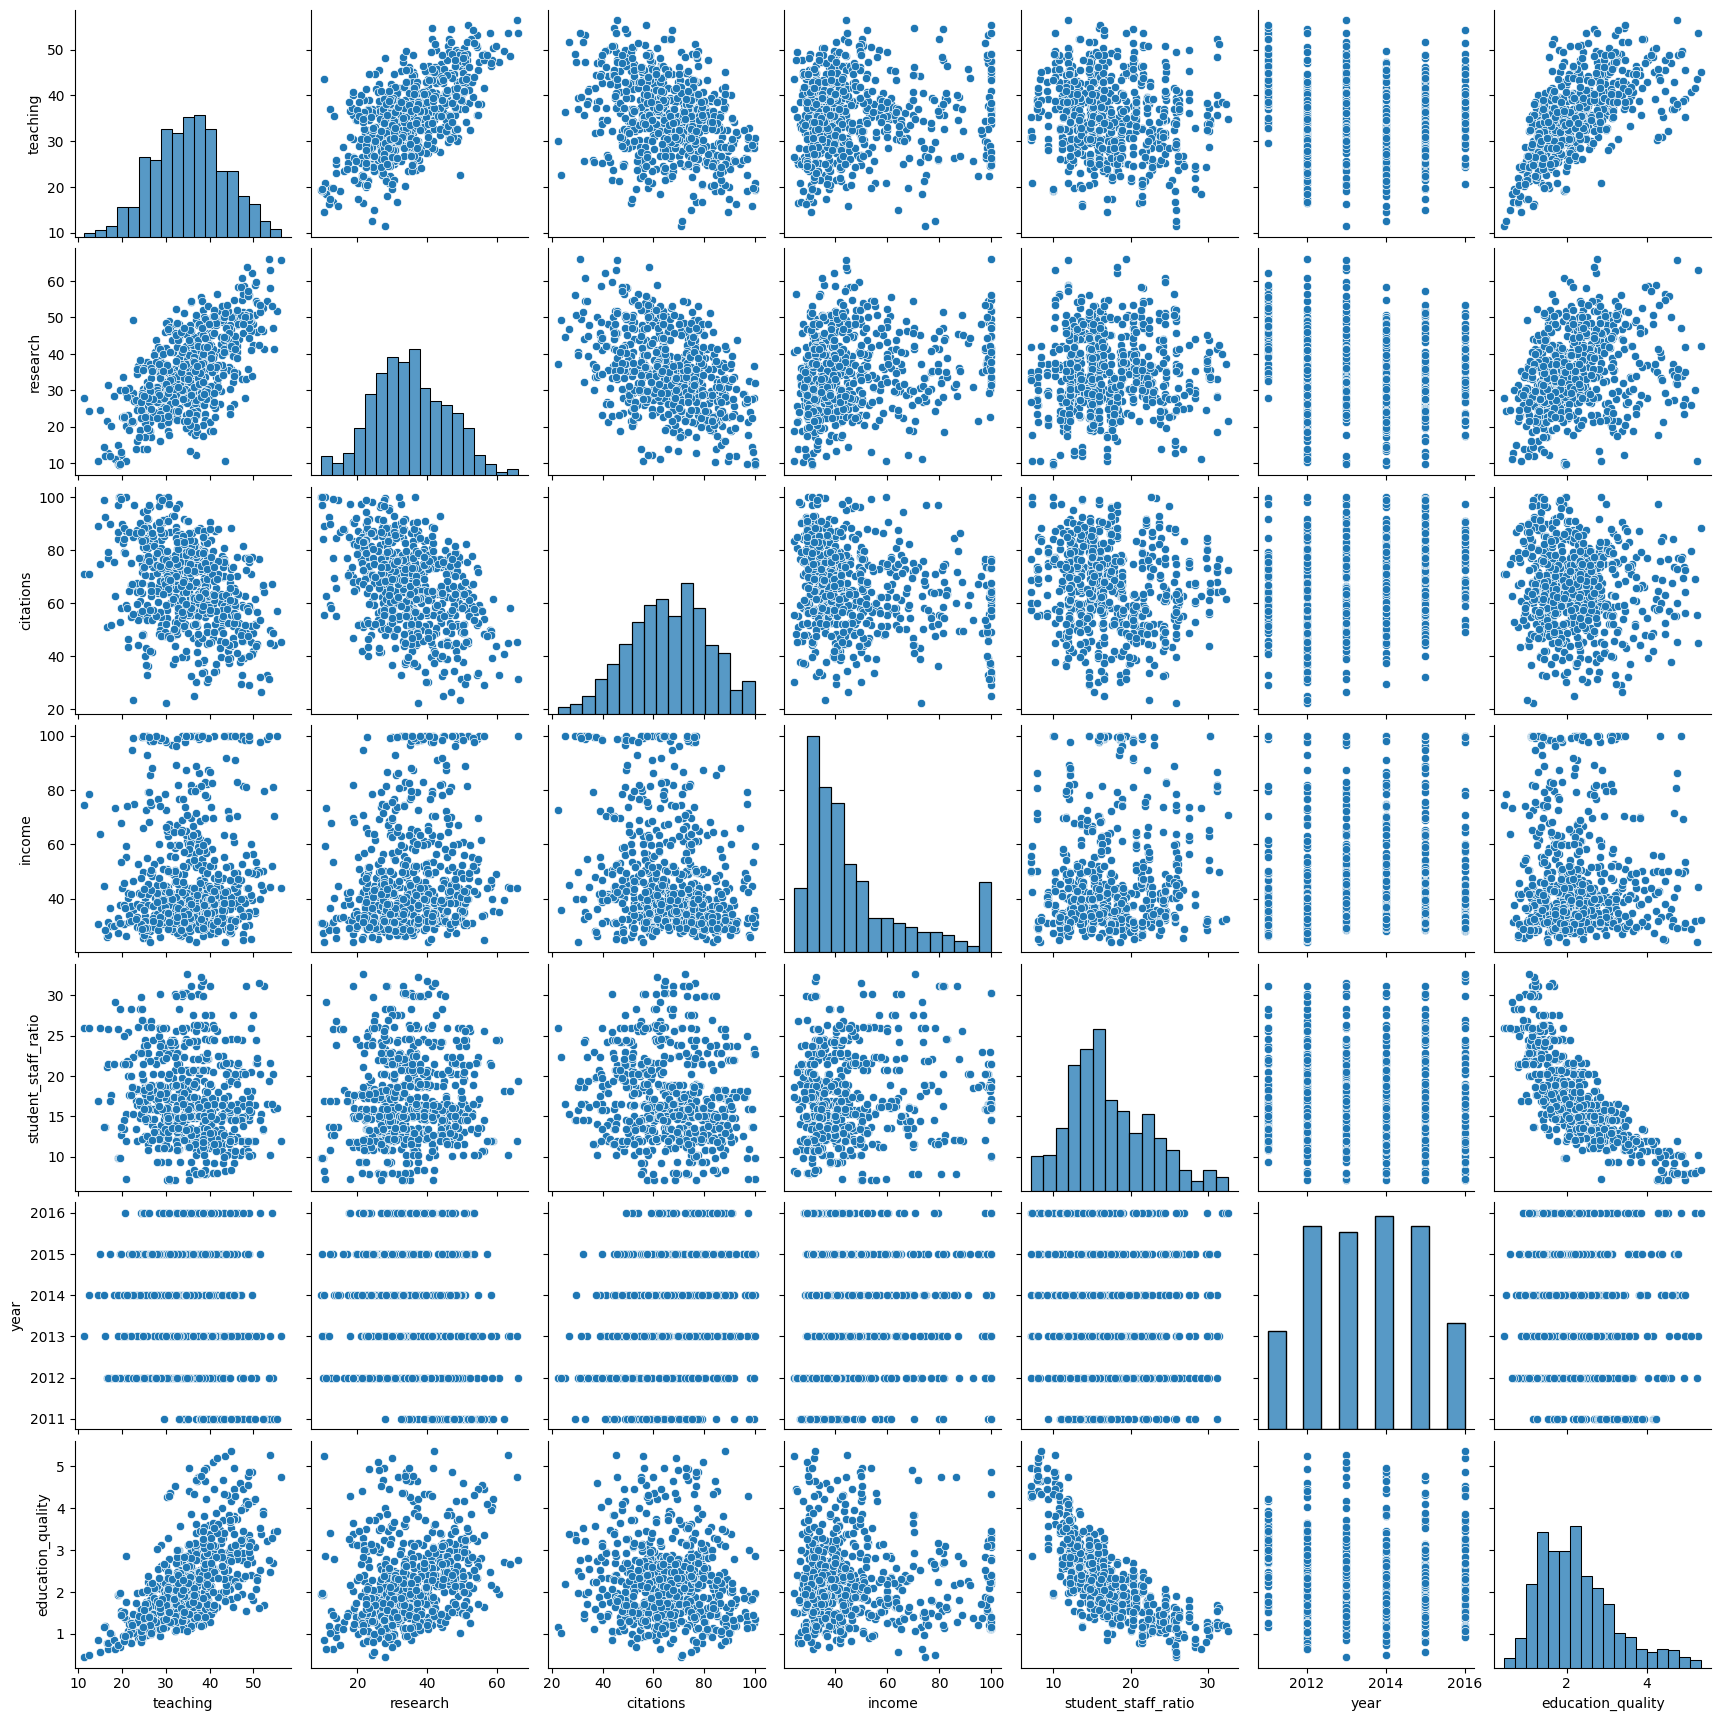

In [16]:
sns.pairplot(df_n)
plt.show()

Можно заметить частичное визуальное разбиение на классы на графике зависимости ```education_quality``` от ```income```

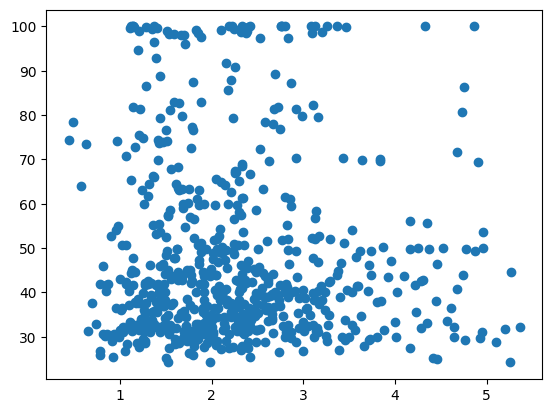

In [19]:
plt.scatter(df_n["education_quality"],df_n["income"])

### Метод локтя

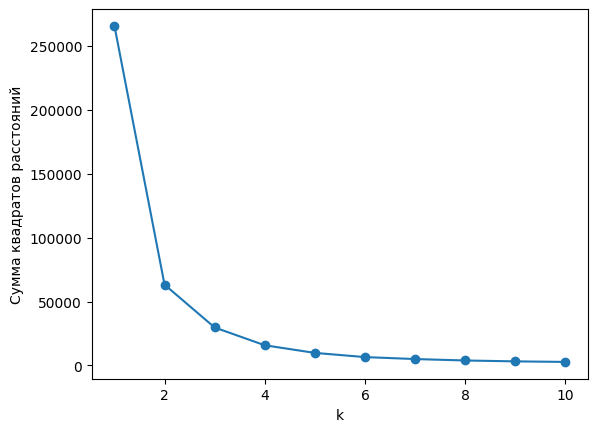

In [24]:
from sklearn.cluster import KMeans
k_range = range(1, 11)

sse = []
for k in range(1, 11):
    km = KMeans(n_clusters = k, n_init = 10)
    km.fit(df_n[['education_quality','income']])
    sse.append(km.inertia_)

plt.xlabel('k')
plt.ylabel('Сумма квадратов расстояний')

plt.plot(k_range, sse)
plt.scatter(k_range, sse)

Исходя из данного графика, оптимальным значением является k=3

## Кластеризация методом K-mean

In [26]:
km = KMeans(n_clusters = 3, n_init = 10)
y_predicted = km.fit_predict(df_n[['education_quality','income']])
df_n["cluster"] = y_predicted
df_n

,teaching,research,citations,income,student_staff_ratio,year,education_quality,cluster
190,43.6,40.4,61.5,32.5,15.7,2011,2.777070,0
174,42.1,40.4,62.8,29.7,14.7,2011,2.863946,0
130,32.9,48.3,79.1,27.4,21.5,2011,1.530233,0
175,46.8,44.1,52.5,38.4,15.0,2011,3.120000,0
128,36.9,49.2,75.9,31.7,23.7,2011,1.556962,0
...,...,...,...,...,...,...,...,...
2007,33.9,36.7,67.8,52.0,16.5,2016,2.054545,2
2054,38.5,17.5,85.0,29.1,11.8,2016,3.262712,0
2053,38.6,32.4,59.0,59.7,20.7,2016,1.864734,2
2034,30.8,17.8,97.4,42.5,7.2,2016,4.277778,0


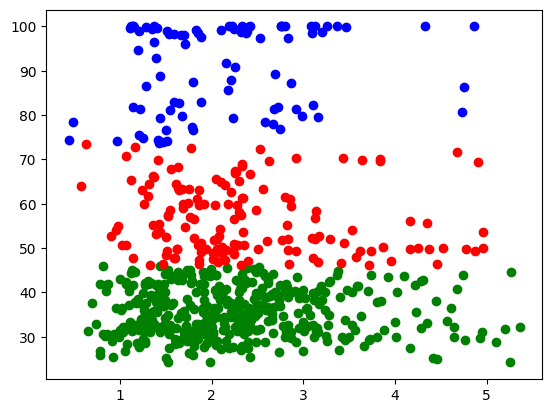

In [27]:
data1 = df_n[df_n.cluster == 0]
data2 = df_n[df_n.cluster == 1]
data3 = df_n[df_n.cluster == 2]

plt.scatter(data1['education_quality'], data1["income"], color='green')
plt.scatter(data2['education_quality'], data2["income"], color='blue')
plt.scatter(data3['education_quality'], data3["income"], color='red')

Каждый цвет обозначает соответствующий ему кластер. Предположение на основании графического метода оказалось справедливым.

## Вывод
В ходе анализа университетских данных мы провели предварительную обработку информации и применили метод кластеризации KMeans. Применение тщательной обработки данных позволило избежать искажений в исходных данных. С использованием графических методов, в частности метода локтя, мы определили оптимальное количество кластеров. Результаты метода локтя подтвердили наше предположение о наличии трех основных групп в данных. Кластерный анализ выявил четко выраженные группы, что успешно отразилось на графике. Наше предварительное предположение о наличии трех групп было подтверждено, и кластеры явно демонстрировали различия между ними. 